In [40]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm

from datetime import date
import time
import calendar
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd

current_date_and_time = time.time() #get the current epoch time

LastDate = int(current_date_and_time) #change the current date into integer format so as to fit into CSV link below

now = datetime.now() #get today's date

last2year = now + relativedelta(years=-2) #get the date 2 years ago from today

last2year_string = last2year.strftime("%a %b %d %H:%M:%S %Y")

StartDate = int(calendar.timegm(time.strptime(last2year_string))) #get the epoch time for the date 2 years ago and convert it to integer

Tickers = ['TSCO.L', 'SBRY.L', '3382.T', 'CA.PA', 'AXFO.ST', 'KR', 'WMT'] #ticker list

dataset = {} #create a dictionary object for containing the stock price for every ticker

#iterate each ticker in the ticker list
for Ticker in Tickers:
        #read the csv file dynamically for every ticker
	df = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{Ticker}?period1={StartDate}&period2={LastDate}&interval=1d&events=history&includeAdjustedClose=true')
	df['Ticker'] = Ticker
	dataset[Ticker] = df
	#time.sleep(1)

StockPrice = pd.concat(dataset) #put stock prices of all tickers together in one table 
StockPrice = StockPrice.reset_index(drop = True) #reset the index
StockPrice = StockPrice.set_index('Ticker')

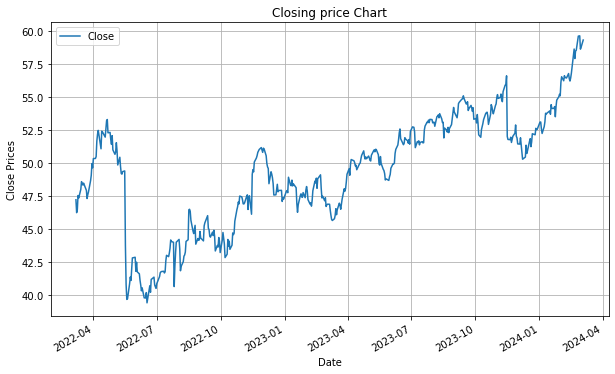

In [41]:
#plot close price in a line chart
df_close = StockPrice.loc['WMT', ['Date', 'Close']]
df_close.reset_index(drop=True, inplace=True)
df_close['Date'] = pd.to_datetime(df_close['Date'], format='%Y-%m-%d') #convert dates to datetime objects
df_close.plot('Date', 'Close', figsize=(10,6))
df_close = df_close.set_index("Date")
df_close.dropna(inplace = True)

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Closing price Chart')
plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

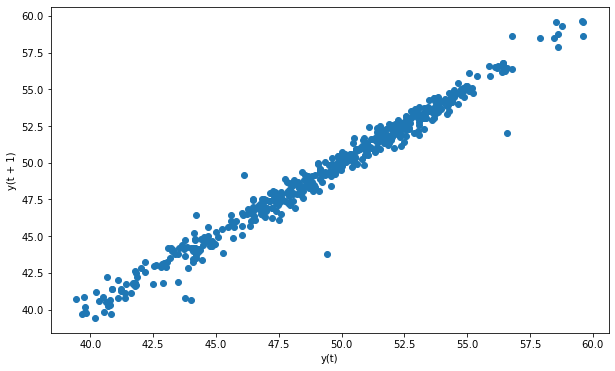

In [42]:
# lagplot
pd.plotting.lag_plot(df_close, lag=1)

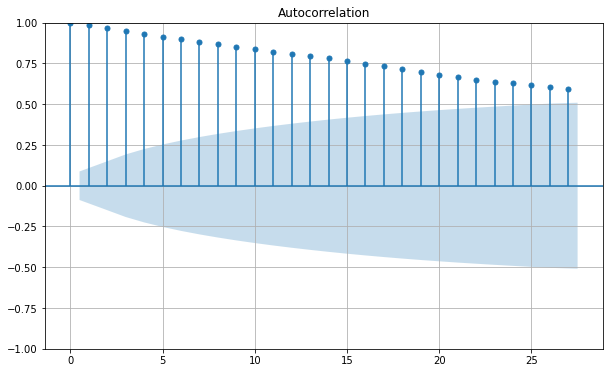

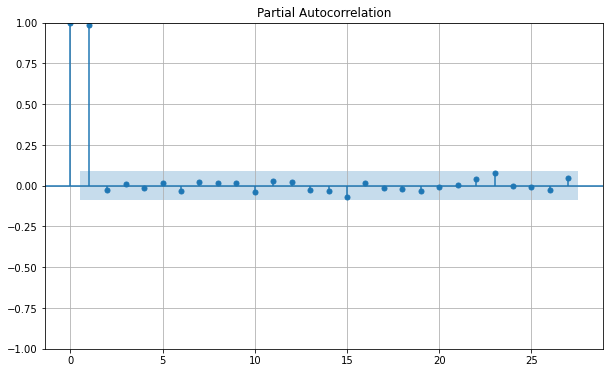

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df_close, alpha = 0.05)
plt.grid(True)
plot_pacf(df_close, alpha = 0.05)
plt.grid(True) #from pacf, p = 1

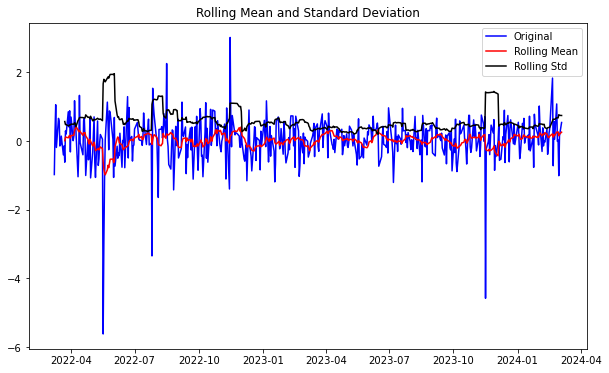

Results of dickey fuller test
Test Statistics                -21.371129
p-value                          0.000000
No. of lags used                 0.000000
Number of observations used    499.000000
critical value (1%)             -3.443523
critical value (5%)             -2.867350
critical value (10%)            -2.569864
dtype: float64


In [44]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    #timeseries.plot(x = 'Date', y = 'Close', figsize=(10,6), color='blue',label='Original')
    plt.plot(timeseries.Close, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries.Close,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
#test_stationarity(df_close.dropna())
test_stationarity(df_close.diff().dropna()) # d = 1 in ARIMA model, as the resulted p is less than 0.05


<Figure size 720x432 with 0 Axes>

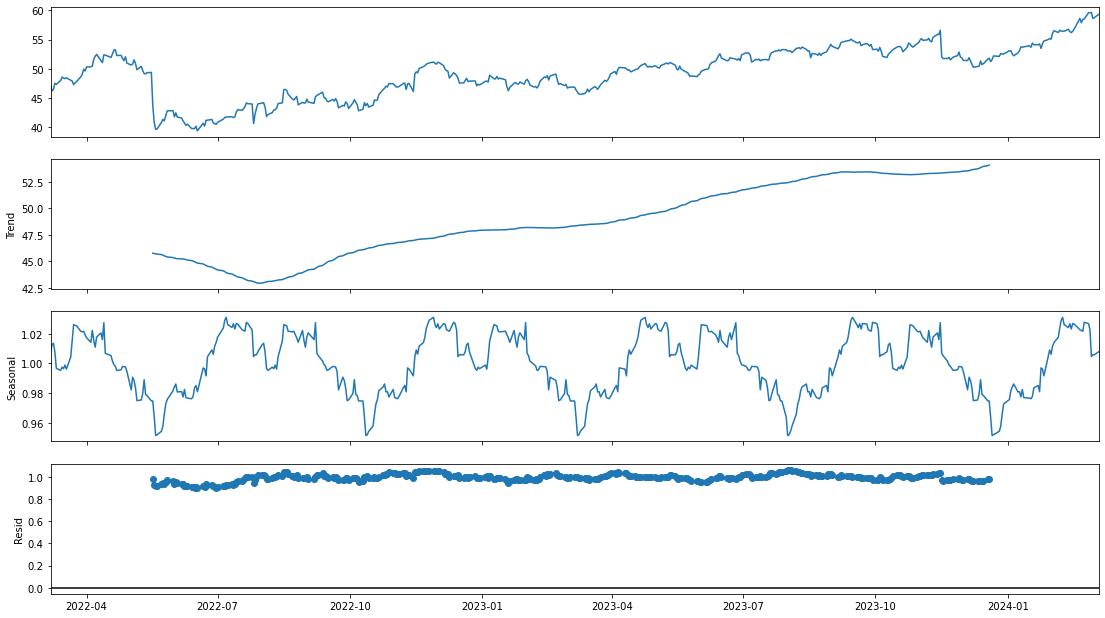

In [45]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 100)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

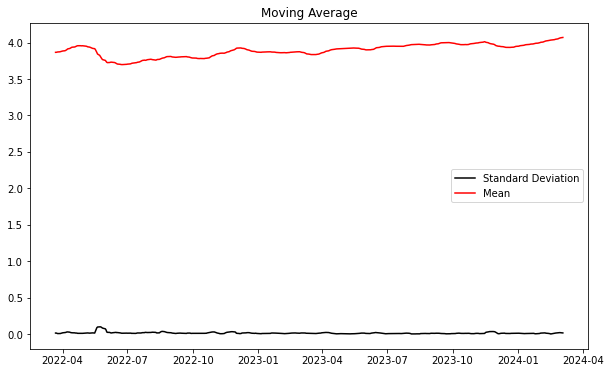

In [46]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = 'Standard Deviation')
plt.plot(moving_avg, color="red", label = 'Mean')
plt.legend(loc = 'best')
plt.show()

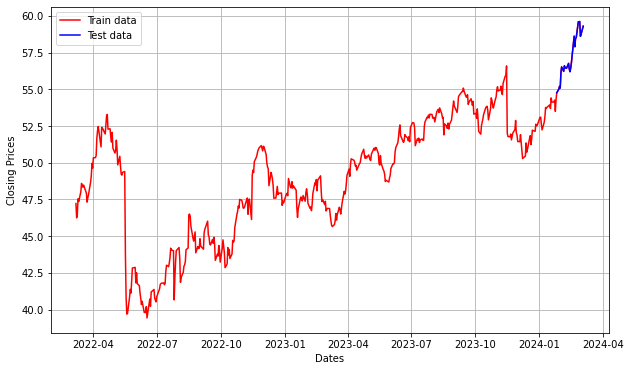

In [62]:
#split data into train and training set
train_data, test_data = df_close.iloc[0:int(len(df_close)*0.95)], df_close.iloc[int(len(df_close)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'red', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [86]:
#Modeling
fitted = sm.tsa.arima.ARIMA(train_data.dropna(), order=(1, 1, 0)).fit()

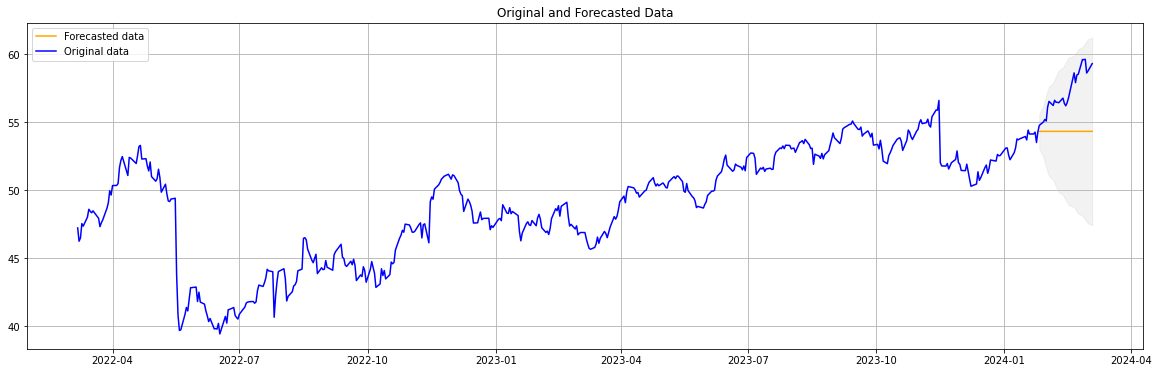

In [87]:
start_index = int(len(df_close)*0.95)
end_index = start_index + len(test_data) - 1

fc = fitted.predict(start = start_index, end = end_index, alpha = 0.05)
forecast = pd.DataFrame(fc)
forecast['Date'] = test_data.index
forecast = forecast.set_index("Date")

fc_interval = fitted.get_prediction(start = start_index, end = end_index)
forecast_int = fc_interval.conf_int(alpha = 0.05)
forecast_int['Date'] = test_data.index
forecast_int = forecast_int.set_index("Date")
forecast_int
forecast_int['Date'] = test_data.index
forecast_int = forecast_int.set_index("Date")

plt.figure(figsize=(20,6))
plt.plot(forecast, 'orange', label='Forecasted data')
plt.plot(df_close, 'blue', label='Original data')
plt.fill_between(forecast_int.index, forecast_int['lower Close'], forecast_int['upper Close'], 
                 color='k', alpha=.05)
plt.legend(loc='upper left')
plt.grid(True)
plt.title('Original and Forecasted Data')
plt.show()

In [88]:
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

RMSE: 3.2188835367772954
